In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pyro
import scipy as sp
import scipy.stats
import time
import torch
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader
    
# Illustrate a few example scenes from the training set
import generate_planar_scene_arrangements as psa_utils
import differentiable_nlp as diff_nlp
from copy import deepcopy

def draw_rbt(ax, rbt, q):
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.2)
    ax.add_patch(patch)
    
def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    draw_rbt(ax, rbt, q)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements
DATA_FILE = "data/20181216_uniform_sorted_feasible_2_box_1000/left_right_sorted.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181216_uniform_sorted_feasible_2_box_1000/left_right_sorted.yaml


Selection of environments from original distribution


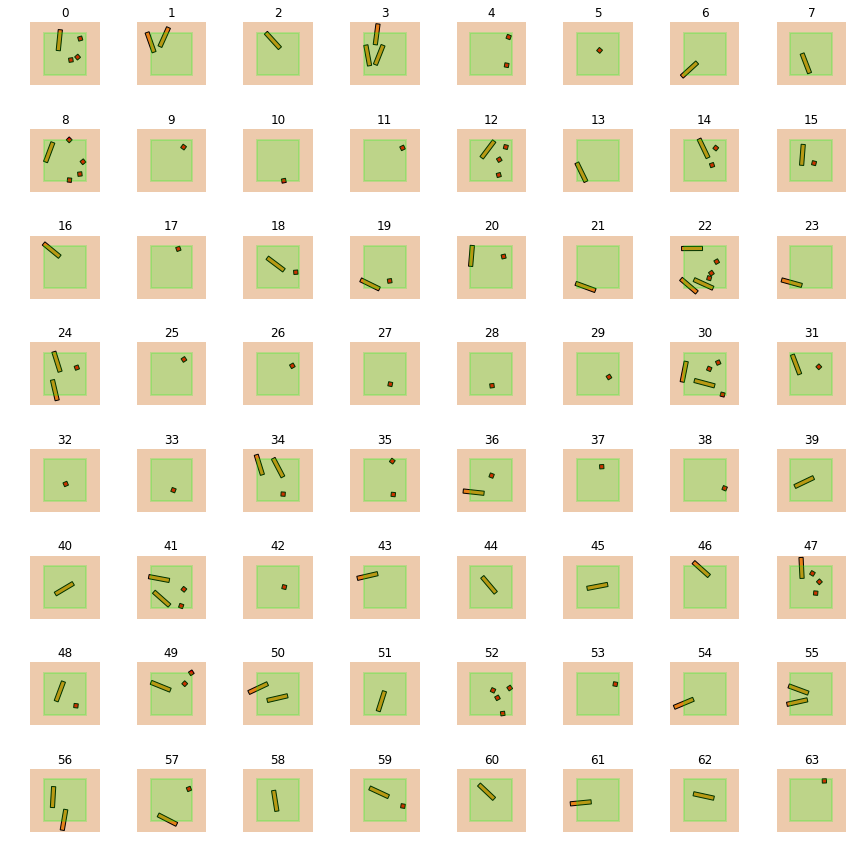

In [46]:
# Illustrate a few example scenes from the training set

plt.figure().set_size_inches(12, 12)
print "Selection of environments from original distribution"
N = 8
for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environments[i*N+j], plt.gca())
        plt.grid(True)
        plt.title("%d" % (i*N+j))
plt.tight_layout()

In [70]:
from collections import namedtuple

def expand_partial_pose_to_full_pose(this_pose):
    full_poses = torch.zeros(this_pose.shape[0], 6,
                             requires_grad=False,
                             dtype=this_pose.dtype)
    full_poses[:, 0] = this_pose[:, 0]
    full_poses[:, 1] = this_pose[:, 1]
    full_poses[:, 5] = this_pose[:, 2]
    return full_poses

def collapse_full_pose_to_partial_pose(pose):
    partial_pose = torch.zeros(pose.shape[0], 3, requires_grad=False,
                       dtype=pose.dtype)
    partial_pose[:, 0] = pose[:, 0]
    partial_pose[:, 1] = pose[:, 1]
    partial_pose[:, 2] = pose[:, 5]
    return partial_pose

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.37698980e-01 -1.52804794e-02  2.62587387e-17 -6.77428891e-08
  2.09494084e-08 -2.01446645e-03]


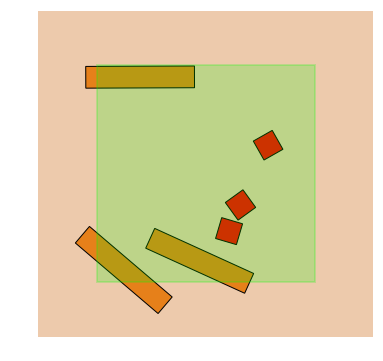

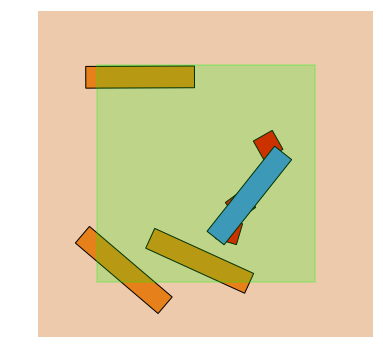

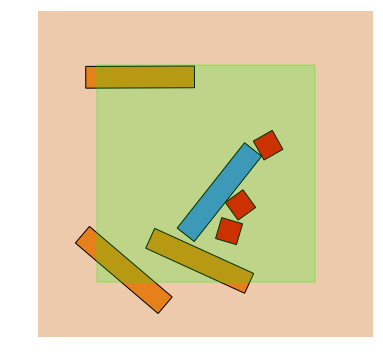

In [94]:
# Making Figure 1, which just demonstrates the process of adding a new thing
base_env = deepcopy(environments[22])
new_example_object = {"class": "long_box_blue", "pose": [0.7, 0.4, 0.9]}

plt.figure().set_size_inches(6, 6)
draw_environment(base_env, plt.gca())
plt.figure().set_size_inches(6, 6)
base_env["n_objects"] += 1
base_env["obj_%04d" % (base_env["n_objects"]-1)] = new_example_object
draw_environment(base_env, plt.gca())

plt.figure().set_size_inches(6, 6)
rbt, q = psa_utils.build_rbt_from_summary(base_env)
q_proj, info, dqf_dq0, _ = diff_nlp.projectToFeasibilityWithIK(
    rbt, q,
    [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
        np.array([0., 0., 0.5]), np.array([1., 1., 0.5])),
     diff_nlp.rbt_at_posture_constraint_constructor_factory(
     range(q.shape[0]-6), q[:-6], q[:-6])])
print q - q_proj
draw_rbt(plt.gca(), rbt, q_proj)


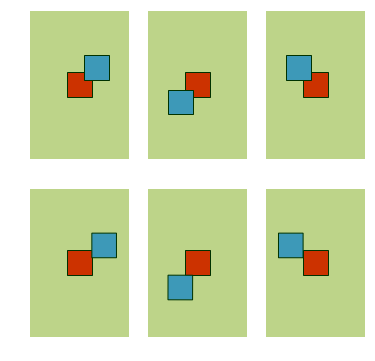

In [124]:
# Making Figure 1, which just demonstrates the process of adding a new thing
base_env = {"n_objects": 2,
           "obj_0000": {"class": "small_box", "pose": [0.5, 0.5, 0.0]},
           "obj_0001": {"class": "small_box_blue", "pose": [0.57, 0.57, 0.0]}}

objs = [{"class": "small_box_blue", "pose": [0.57, 0.57, 0.0]},
     {"class": "small_box_blue", "pose": [0.43, 0.43, 0.0]},
     {"class": "small_box_blue", "pose": [0.43, 0.57, 0.0]}]
    
             
plt.figure().set_size_inches(6, 12)
for k in range(3):
    plt.subplot(2, 3, k+1)
    
    base_env["obj_0001"] = objs[k]
    draw_environment(base_env, plt.gca())
    plt.xlim(0.3, 0.7)
    plt.ylim(0.3, 0.7)

    plt.subplot(2, 3, k+4)
    rbt, q = psa_utils.build_rbt_from_summary(base_env)
    q_proj, info, dqf_dq0, _ = diff_nlp.projectToFeasibilityWithIK(
        rbt, q,
        [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
            np.array([0., 0., 0.5]), np.array([1., 1., 0.5])),
         diff_nlp.rbt_at_posture_constraint_constructor_factory(
         range(6), q[:6], q[:6])])
    draw_rbt(plt.gca(), rbt, q_proj)
    plt.xlim(0.3, 0.7)
    plt.ylim(0.4, 0.6)
